In [31]:
from IPython import display
from utils import Logger
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import copy

In [32]:
def Fashion_mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])]
         #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        )
    out_dir = './dataset'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)



# Load data
data = Fashion_mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)  #600*100
num_batches

600

In [66]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, labels], 1)
        out = self.model(x)
        #return out.squeeze()
        return out


discriminator = DiscriminatorNet()

In [67]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
                

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, labels], 1)
        out = self.model(x)
    
generator = GeneratorNet()

In [68]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [69]:
def con_noise(size,l_onehot):
      
    noise=torch.randn(size,90)    
    fake_data=torch.cat((l_onehot,noise),1)   
    n = Variable(fake_data)
    return n

In [70]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [71]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [72]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [73]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

In [74]:
def train_discriminator(optimizer, real_data, fake_data,labels):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data, labels)
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data,labels)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake



In [75]:
def train_generator(optimizer, fake_data,labels):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data,labels)
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [76]:
num_test_samples = 8
test_noise = noise(num_test_samples)

In [81]:
## test code

for inputs, labels in data_loader:
    #inpt=inputs.view(inputs.size(0), 784)
    #one_hot = torch.nn.functional.one_hot(labels, 10)  #size=(15, 15, n)
    #real_data=torch.cat((one_hot,inpt),1)
    real_data= Variable(images_to_vectors(inputs))
    one_hot = torch.nn.functional.one_hot(labels, 10)
    if torch.cuda.is_available(): real_data = real_data.cuda()      
    #fake_data = generator(noise(real_data.size(0)),one_hot)
    fake_data = generator(noise(real_data.size(0)),one_hot)
    
print(fake_data)

None


In [80]:
torch.cat([noise(100), one_hot], 1)

tensor([[ 1.3293, -1.8548, -0.6686,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.2080,  1.9889, -1.3496,  ...,  0.0000,  1.0000,  0.0000],
        [-1.4159, -0.0941, -0.5902,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3809,  0.2221, -0.9593,  ...,  0.0000,  0.0000,  0.0000],
        [-1.5730,  0.2969,  1.2792,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.9112,  0.2616, -1.0666,  ...,  0.0000,  0.0000,  0.0000]])

In [28]:
logger = Logger(model_name='VGAN', data_name='MNIST')

D_loss=[]
G_loss=[]
N=600
num_epochs=50
for epoch in range(num_epochs):
    LossD=0
    LossG=0
    for inputs, labels in data_loader:

        # 1. Train Discriminator
        #inpt=inputs.view(inputs.size(0), 784)
          
        #real_data=torch.cat((one_hot,inpt),1)   # one_hot + input data    
        real_data= Variable(images_to_vectors(inputs))
        one_hot = torch.nn.functional.one_hot(labels, 10)
        if torch.cuda.is_available(): real_data = real_data.cuda()      
        fake_data = generator(noise(real_data.size(0),one_hot).detach()
        
        # Train D
        #d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,real_data,fake_data,one_hot)
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,real_data, fake_data,one_hot)
                                                                
                                                                
        LossD+=d_error.item()

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_data.size(0), one_hot)
        # Train G
        g_error = train_generator(g_optimizer, fake_data, one_hot)       
        # Log error
        #logger.log(d_error, g_error, epoch, n_batch, num_batches)
        LossG+=g_error.item()
        #print('b_derror:',d_error, 'b_gerror:',g_error)
    D_loss.append(LossD/N)
    G_loss.append(LossG/N)
    print('D:',LossD/N,'G:',LossG/N)
print(D_loss,G_loss)  

SyntaxError: invalid syntax (<ipython-input-28-86df57379489>, line 23)

In [ ]:
        
    
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
    

Text(0, 0.5, 'Training Loss')

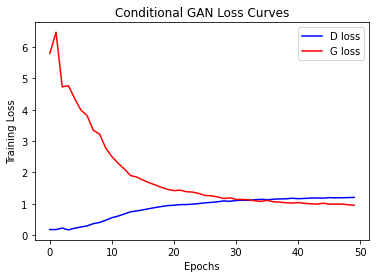

In [174]:
## plot 
plt.title('Conditional GAN Loss Curves')
plt.plot(D_loss,'b')
plt.plot(G_loss,'r')
plt.legend(['D loss','G loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

In [ ]:
def con_noise(size,l_onehot):
      
    noise=torch.randn(size,90)    
    fake_data=torch.cat((l_onehot,noise),1)   
    n = Variable(fake_data)
    return n

In [175]:
lab=torch.tensor([0,1,2,3,4,5,6,7,8,9])
l_onehot = torch.nn.functional.one_hot(lab, 10) 
ll=torch.cat((l_onehot,l_onehot,l_onehot),0)   


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

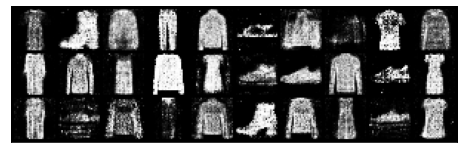

In [213]:
from torchvision.utils import make_grid
test_data=con_noise(30,ll)
gen=generator(test_data)
img=gen[:,10:].view(30, 1, 28, 28).data.cpu()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(img, nrow=10, normalize=True, scale_each=True).permute(1, 2, 0))


In [ ]:
## 以下没啥用了

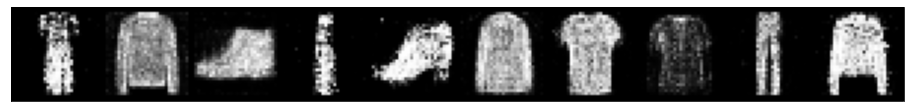

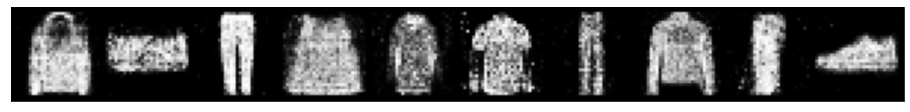

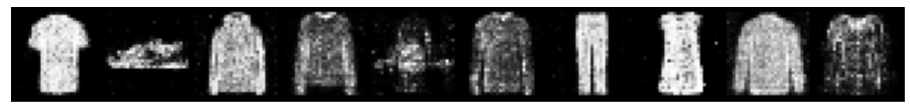

In [196]:
from torchvision.utils import make_grid
for i in range(3):
    test_data=con_noise(10,l_onehot)
    gen=generator(test_data)
    img=gen[:,10:].view(10, 1, 28, 28).data.cpu()

    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img, nrow=10, normalize=True, scale_each=True).permute(1, 2, 0))

In [195]:
num_test_samples = 10
test_noise = noise(num_test_samples)
test_images = vectors_to_images(generator(test_noise)).data.cpu()
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

RuntimeError: shape '[10, 1, 28, 28]' is invalid for input of size 7940

In [136]:
#def con_noise(size,labels):
    
    lab=torch.tensor([0,1,2,3,4,5,6,7,8,9])
    l_onehot = torch.nn.functional.one_hot(lab, 10)    
    inpt=torch.randn(size,90)    
    fake_data=torch.cat((l_onehot,inpt),1)   
    n = Variable(fake_data)
    #return n
test_noise = con_noise(10)
gen=generator(test_noise)
img=gen[:,10:].view(10, 1, 28, 28).data.cpu()
test_noise[4,0:9]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [192]:
#plot 
from torchvision.utils import make_grid
for i in range(3):
    test_noise = con_noise(10,)
    gen=generator(test_noise)
    img=gen[:,10:].view(10, 1, 28, 28).data.cpu()
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img, nrow=10,normalize=True, scale_each=True).permute(1, 2, 0))
    

TypeError: con_noise() missing 1 required positional argument: 'l_onehot'

In [138]:
num_test_samples = 3
test_noise=noise(num_test_samples)
test_noise.shape

torch.Size([3, 100])

In [93]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break
show_batch(train_dl)

torch.Size([94])

In [95]:
torch.zeros(3, 10)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [100]:
lab=torch.tensor([0,1,2,3,4,5,6,7,8,9])
l_onehot = torch.nn.functional.one_hot(lab, 10)    
inpt=torch.randn(10,90)    
fake_data=torch.cat((l_onehot,inpt),1)   


tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.5611e+00, -1.2649e-01, -1.1530e+00, -3.6026e-01, -2.9407e+00,
         -1.5642e+00, -4.6325e-01, -7.6807e-01, -1.5754e+00,  3.6742e-01,
         -7.6232e-01,  4.5215e-01, -1.3016e+00,  1.2322e+00,  7.2502e-01,
          7.2331e-02,  4.2263e-01, -1.0185e+00,  1.5082e+00,  1.0027e+00,
         -9.5214e-01,  1.9263e-01, -1.5926e+00, -2.0171e-01,  1.9666e-01,
          1.7310e+00, -4.6333e-01, -1.1720e+00,  2.3609e-01, -3.9982e-01,
         -1.3815e+00,  1.5173e-01, -2.0741e-01, -6.6854e-01, -5.1005e-01,
          2.7265e-01,  1.7922e-01,  7.7429e-01,  1.5996e+00, -7.8804e-01,
          1.5505e+00,  2.7539e+00,  5.8381e-01,  6.5641e-01,  1.1215e+00,
         -1.3306e+00, -2.6121e-01,  2.7109e-01, -4.8817e-02, -1.6064e+00,
         -1.9047e-01,  1.4742e+00, -9.5158e-01,  2.2974e-01, -1.7172e-01,
          9.0050e-01, -7.3153e-01,  1.